In [34]:
# ============================================
# Common Setup: Import all required libraries
# (Used across Part 1, 2, 3, 4)
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as tq

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import time


In [35]:
# ============================================
# PART 1: DATA PREPARATION
# - Load CIFAR10 dataset
# - Resize images (32x32)
# - Normalize pixel values
# - Split into Train / Validation / Test sets
# ============================================

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

full_train = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_data = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size

train_data, val_data = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

print("Train:", len(train_data), " | Validation:", len(val_data), " | Test:", len(test_data))


Train: 40000  | Validation: 10000  | Test: 10000


In [36]:
# ============================================
# PART 2: MODEL DESIGN
# Implement a compact CNN suitable for CIFAR10
# ============================================

class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        self.fc1 = nn.Linear(128*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv2(torch.relu(self.conv1(x)))))
        x = self.pool(torch.relu(self.conv4(torch.relu(self.conv3(x)))))
        x = x.view(-1, 128*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFARCNN()
model


CIFARCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
# ============================================
# PART 2: TRAINING
# - Train the CNN model
# - Track Training & Validation Loss/Accuracy
# ============================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # -------- TRAIN --------
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # -------- VALIDATION --------
    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            out = model(images)
            loss = criterion(out, labels)

            val_loss += loss.item()
            _, pred = torch.max(out, 1)
            v_total += labels.size(0)
            v_correct += (pred == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(v_correct / v_total)

    print(f"[Epoch {epoch+1}/{epochs}] "
          f"Train Acc={train_accs[-1]:.4f} | Val Acc={val_accs[-1]:.4f}")


[Epoch 1/5] Train Acc=0.4875 | Val Acc=0.6290
[Epoch 2/5] Train Acc=0.6888 | Val Acc=0.7123
[Epoch 3/5] Train Acc=0.7671 | Val Acc=0.7339
[Epoch 4/5] Train Acc=0.8260 | Val Acc=0.7460
[Epoch 5/5] Train Acc=0.8758 | Val Acc=0.7566


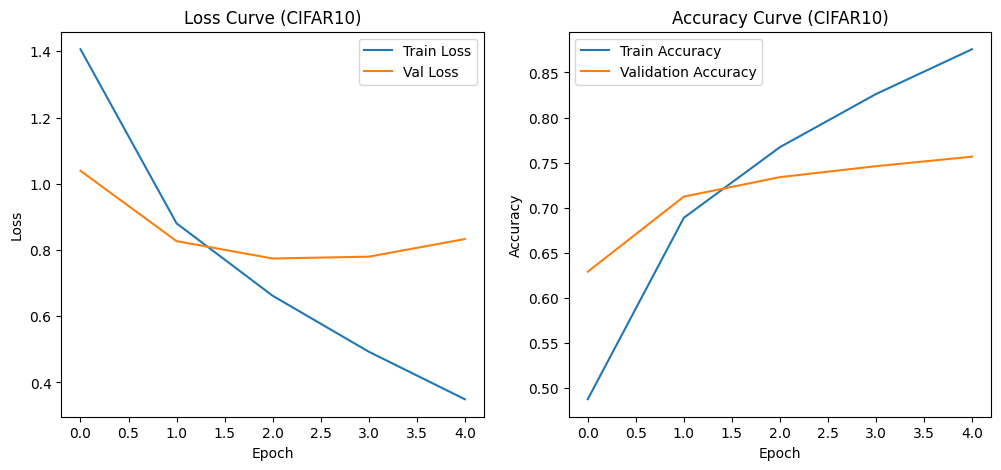

In [38]:
# ============================================
# PART 2: VISUALIZATION
# - Plot training and validation loss/accuracy curves
# ============================================

plt.figure(figsize=(12,5))

# LOSS curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (CIFAR10)")
plt.legend()

# ACC curve
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve (CIFAR10)")
plt.legend()

plt.show()


In [39]:
# ============================================
# PART 2: FINAL TEST ACCURACY
# ============================================

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        out = model(images)
        _, pred = torch.max(out, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

test_acc = correct / total
print("Final Test Accuracy:", test_acc)


Final Test Accuracy: 0.7536


In [40]:
# ============================================
# PART 3: MODEL QUANTIZATION (PTQ)
# - Apply post-training dynamic quantization
# ============================================

quantized_model = tq.quantize_dynamic(
    model,            # 이미 학습을 마친 float32 모델.
    {nn.Linear},      # 어떤 layer를 양자화할지 지정. 여기서는 Linear만.
    dtype=torch.qint8 # 8비트 정수(int8)로 양자화.
)

quantized_model
# 양자화된 모델 구조 출력 (Linear 레이어들이 QuantizedLinear 등으로 바뀜)



C:\Users\zuiga\AppData\Local\Temp\ipykernel_35372\673317086.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = tq.quantize_dynamic(


CIFARCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=8192, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=256, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [41]:
# ============================================
# PART 3: MODEL SIZE COMPARISON
# ============================================

import os

torch.save(model.state_dict(), "fp32.pth")
torch.save(quantized_model.state_dict(), "int8.pth")

fp32_size = os.path.getsize("fp32.pth")/1024
int8_size = os.path.getsize("int8.pth")/1024

print(f"FP32 Model Size: {fp32_size:.2f} KB")
print(f"INT8 Model Size: {int8_size:.2f} KB")

FP32 Model Size: 9147.57 KB
INT8 Model Size: 2997.36 KB


In [42]:
# ============================================
# PART 3: QUANTIZED MODEL ACCURACY
# ============================================

quant_correct, quant_total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        out = quantized_model(images)
        _, pred = torch.max(out, 1)
        quant_total += labels.size(0)
        quant_correct += (pred == labels).sum().item()

quant_acc = quant_correct / quant_total
print("Quantized Test Accuracy:", quant_acc)


Quantized Test Accuracy: 0.7542


In [43]:
# ============================================
# PART 3: INFERENCE TIME COMPARISON (CPU)
# ============================================

def measure_inference(model):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            _ = model(images)
    end = time.time()
    return end - start

fp32_time = measure_inference(model)
int8_time = measure_inference(quantized_model)

print("FP32 Inference Time:", fp32_time)
print("INT8 Inference Time:", int8_time)


FP32 Inference Time: 24.631691217422485
INT8 Inference Time: 20.557770013809204
